# Spatial audio in VR - Experiment results

In [1]:
# Required imports

import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt

In [2]:
# Helper functions and variables
def percentage(v, total, round_pct=True):
    val = v / float(total) * 100
    return f"{round(val, 2)}%" if round_pct else f"{val}%"


UTF_DATE = "%Y-%m-%dT%H:%M:%SZ"
P_DATE = "%d-%m-%Y %H:%M:%S"

SOUND_COUNT = 10

In [3]:
# Read participants data
participants_df = pd.read_csv("./data/participants.csv")
participants_df['Sex'] = participants_df['Sex'].replace(['Man', 'Vrouw'], ['M', 'F'])
participants_df['VR Experience'] = participants_df['VR Experience'].replace(
    ['Geen', 'Wel al eens geprobeerd', 'Speelt af en toe', 'Speelt regelmatig', 'Speelt wekelijks'],
    [0, 1, 2, 3, 4]
)
participants_df['Timestamp'] = pd.to_datetime(participants_df.Timestamp, format=P_DATE)

participants_df.head(15)

,Timestamp,Age,Sex,Occupation/study,VR Experience,HPosScore,VPosScore,SoundDistEstimate,SoundNatureScore,ControlsScore,MotionSickness,Feedback
0,2022-05-20 14:20:59,22,M,informatica,0,2,4,4,2,5,1,/
1,2022-05-21 11:37:04,16,F,humane wetenschappen,1,4,4,3,5,5,1,NaN
2,2022-05-21 12:45:10,20,M,Farmaceutische en biologische laboratoriumtech...,1,4,3,4,5,4,1,NaN
3,2022-05-21 12:55:56,53,M,Docent verpleegkunde,1,5,5,5,5,5,1,"Vlot te hanteren, leuk, eenvoudige besturing"
4,2022-05-21 20:38:28,52,M,bediende,1,4,4,4,5,5,1,NaN
5,2022-05-21 20:48:06,54,F,bediende,0,3,3,3,4,4,1,NaN
6,2022-05-21 21:01:03,22,F,Lager onderwijs,1,3,4,3,4,5,3,Het was enorm leuk om te doen!
7,2022-05-21 21:21:47,20,M,Audiovisuele technieken,1,4,4,3,4,5,1,NaN
8,2022-05-22 10:50:37,50,M,leerkracht,1,4,3,3,4,5,3,"ik zat er helemaal ""in"" - hoofddoel is muntjes..."
9,2022-05-22 16:29:29,77,F,Gepensioneerd,0,4,2,3,3,2,1,In het begin ging het moeizamer (voor besturin...


In [4]:
# Read rotation data

rot_loc_dfs = list()

for filename in os.listdir("./data/rotation-location"):
    rot_loc_dfs.append(
        pd.read_csv(f"./data/rotation-location/{filename}", delimiter=';')
    )

rot_loc_dfs[0].head()

,time,position,rotationE,rotationQ
0,2022-05-20T14:11:49Z,"(0.01216268,2.489398,-0.1615756)","(353.3962,276.6872,359.3815)","(0.7456865,-0.0394508,-0.6637812,-0.04230781)"
1,2022-05-20T14:11:49Z,"(0.01043249,2.190978,-0.1597213)","(354.053,276.0133,359.1425)","(0.7419415,-0.03355309,-0.6684132,-0.04025945)"
2,2022-05-20T14:11:49Z,"(0.009028446,2.189787,-0.1574484)","(354.55,275.8416,358.922)","(0.7410472,-0.02898795,-0.669702,-0.03883384)"
3,2022-05-20T14:11:49Z,"(0.008340128,2.188898,-0.1555549)","(354.9409,276.1456,358.8665)","(0.7429413,-0.02623146,-0.667827,-0.03684012)"
4,2022-05-20T14:11:49Z,"(0.008264536,2.188483,-0.1530411)","(355.2329,276.1987,358.8331)","(0.7433386,-0.02415862,-0.6675438,-0.0353458)"


In [5]:
# Read SFX data

# sfx dataframe headers:
# sound_name;sound_type;sound_pos;start_time;end_time;look_start;look_end;look_range

sfx_dfs = list()


def get_next_sound_data(remaining_lines):
    while remaining_lines and not remaining_lines[0].startswith("[SOUND_START];"):
        remaining_lines.pop(0)

    data = [remaining_lines.pop(0)]

    while remaining_lines and not remaining_lines[0].startswith("[SOUND_STOP];"):
        l = remaining_lines.pop(0)
        if l and not l.startswith("[SOUND_START]"):
            data.append(l)

    if remaining_lines:
        data.append(remaining_lines.pop(0))
    else:
        # Last entry of file does not have STOP timing information, construct it ourselves

        information_parts = data[0].split(';')
        information_parts[0] = "[SOUND_STOP]"

        # Set time to last watch time, this is allowed since application stops logging when last coin is collected
        last_entry_time = data[-1].split(';')[0]
        information_parts[1] = last_entry_time

        data.append(';'.join(information_parts))

    return data


for person_id, filename in enumerate(os.listdir("./data/sfx-info")):
    df_entries = list()
    with open(f"./data/sfx-info/{filename}") as f:
        # Skip first two lines
        lines = f.readlines()[2:]

        # Remove empty lines
        lines = [l for l in lines if l.strip()]
        # lines = list(dict.fromkeys(lines))

        while lines:
            sound_data = get_next_sound_data(lines)
            sound_data = list(dict.fromkeys(sound_data))  # Remove duplicate time entries

            _, start_time, sname, stype, spos = sound_data[0].split(';')
            _, end_time, _, _, _ = sound_data[-1].split(';')

            data_points = sound_data[1:-1]

            sound_info = [person_id, sname, stype, eval(spos), start_time, end_time]

            look_start = None
            for i, dp in enumerate(data_points):
                time_entry, dp_range = dp.split(';')
                if not look_start:
                    look_start = time_entry

                if i == 0:
                    continue

                prev_time, prev_range = data_points[i - 1].split(';')

                time_entry_obj = datetime.datetime.strptime(time_entry, UTF_DATE)
                prev_time_obj = datetime.datetime.strptime(prev_time, UTF_DATE)

                if prev_range != dp_range:
                    df_entries.append(
                        [*sound_info, look_start, prev_time, prev_range]
                    )
                    look_start = time_entry
                    continue

                # Difference greater than 1 second ==> player looked away and then looked back
                diff = prev_time_obj - time_entry_obj
                if (time_entry_obj - prev_time_obj).seconds > 1:
                    df_entries.append(
                        [*sound_info, look_start, prev_time, prev_range]
                    )
                    look_start = time_entry
                    continue

            if len(data_points) > 0:
                last_time, last_range = data_points[-1].split(';')
                df_entries.append(
                    [*sound_info, look_start, last_time, last_range]
                )

    sfx_dfs.append(
        pd.DataFrame(df_entries,
                     columns=["PersonID", "Name", "Type", "Pos", "PlayStart", "PlayEnd", "LookStart", "LookEnd",
                              "RangeType"])
    )

# Data cleanup
for sdf in sfx_dfs:
    date_cols = ["PlayStart", "PlayEnd", "LookStart", "LookEnd"]
    for c in date_cols:
        sdf[c] = sdf[c].apply(lambda x: datetime.datetime.strptime(x, UTF_DATE))
    sdf["RangeType"] = sdf["RangeType"].apply(lambda x: x.strip())

sfx_dfs[0].head(1000)

,PersonID,Name,Type,Pos,PlayStart,PlayEnd,LookStart,LookEnd,RangeType
0,0,ambisonic-chicken-edited,AS,"(-19, 1, -5)",2022-05-20 14:11:58,2022-05-20 14:11:58,2022-05-20 14:11:58,2022-05-20 14:11:58,far
1,0,bird,NSS,"(24, 7, -14)",2022-05-20 14:12:19,2022-05-20 14:12:31,2022-05-20 14:12:22,2022-05-20 14:12:23,far
2,0,creak,NUS,"(-5, 3, 25)",2022-05-20 14:12:55,2022-05-20 14:13:53,2022-05-20 14:12:56,2022-05-20 14:12:57,far
3,0,door_crack,NNS,"(-8, 2, -26)",2022-05-20 14:14:02,2022-05-20 14:14:20,2022-05-20 14:14:03,2022-05-20 14:14:03,far
4,0,door_crack,NNS,"(-8, 2, -26)",2022-05-20 14:14:02,2022-05-20 14:14:20,2022-05-20 14:14:09,2022-05-20 14:14:11,far
5,0,australian-currawong-edited,AS,"(-32, 4, -34)",2022-05-20 14:14:37,2022-05-20 14:14:50,2022-05-20 14:14:39,2022-05-20 14:14:39,far
6,0,australian-currawong-edited,AS,"(-32, 4, -34)",2022-05-20 14:14:37,2022-05-20 14:14:50,2022-05-20 14:14:43,2022-05-20 14:14:43,far
7,0,elevator-edited,AN,"(-18, 3, 18)",2022-05-20 14:15:09,2022-05-20 14:15:18,2022-05-20 14:15:11,2022-05-20 14:15:11,far
8,0,elevator-edited,AN,"(-18, 3, 18)",2022-05-20 14:15:09,2022-05-20 14:15:18,2022-05-20 14:15:16,2022-05-20 14:15:16,far
9,0,creak,NUS,"(-5, 3, 25)",2022-05-20 14:15:18,2022-05-20 14:15:18,2022-05-20 14:15:18,2022-05-20 14:15:18,far


## Participants Information

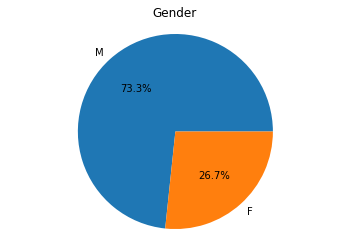

In [6]:
# TODO
v_counts = participants_df['Sex'].value_counts()
fig, ax = plt.subplots()
plt.title('Gender')
ax.pie(v_counts.to_list(), labels=['M', 'F'], autopct='%1.1f%%')
ax.axis('equal')
plt.show()
plt.close()

Most participants are male (73.3%, 11/15).

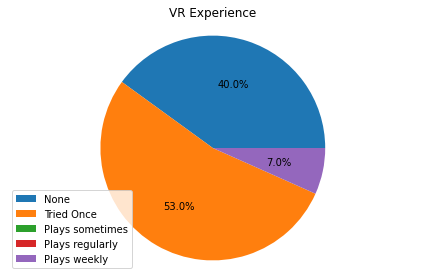

In [7]:
vr_experience = participants_df['VR Experience'].value_counts()
vr_experience = [vr_experience.get(v, 0) for v in range(5)]

plt.title('VR Experience')
plt.pie(vr_experience, autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '')
plt.legend(labels=["None", "Tried Once", "Plays sometimes", "Plays regularly", 'Plays weekly'])
plt.axis('equal')
plt.tight_layout()
plt.show()

Most participants had little to no experience with VR. One experienced VR user participated.

The age of the participants varied between 16 and 77.
Most participants are students.
Most participants study/work in an IT related sector.

In [8]:
def column_to_list(the_df, col_name):
    col = the_df[col_name].value_counts()
    return [col.get(v, 0) for v in range(1, 6)]


hpos_scores = column_to_list(participants_df, 'HPosScore')
vpos_scores = column_to_list(participants_df, 'VPosScore')
sound_dist_est = column_to_list(participants_df, 'SoundDistEstimate')
sound_nature = column_to_list(participants_df, 'SoundNatureScore')
controls_score = column_to_list(participants_df, 'ControlsScore')
motion_sickness_score = column_to_list(participants_df, 'MotionSickness')


def add_labels(x, y, axis):
    for i in range(len(x)):
        if y[i]:
            axis.text(i + 1, y[i] - .55, y[i], ha='center',
                      bbox=dict(facecolor='white', alpha=.5))


def create_bar(x, y, title, label_x, label_y, axis):
    axis.bar(x, y)
    add_labels(x, y, axis)
    axis.set_title(title)
    axis.set(xlabel=label_x, ylabel=label_y)
    return plt



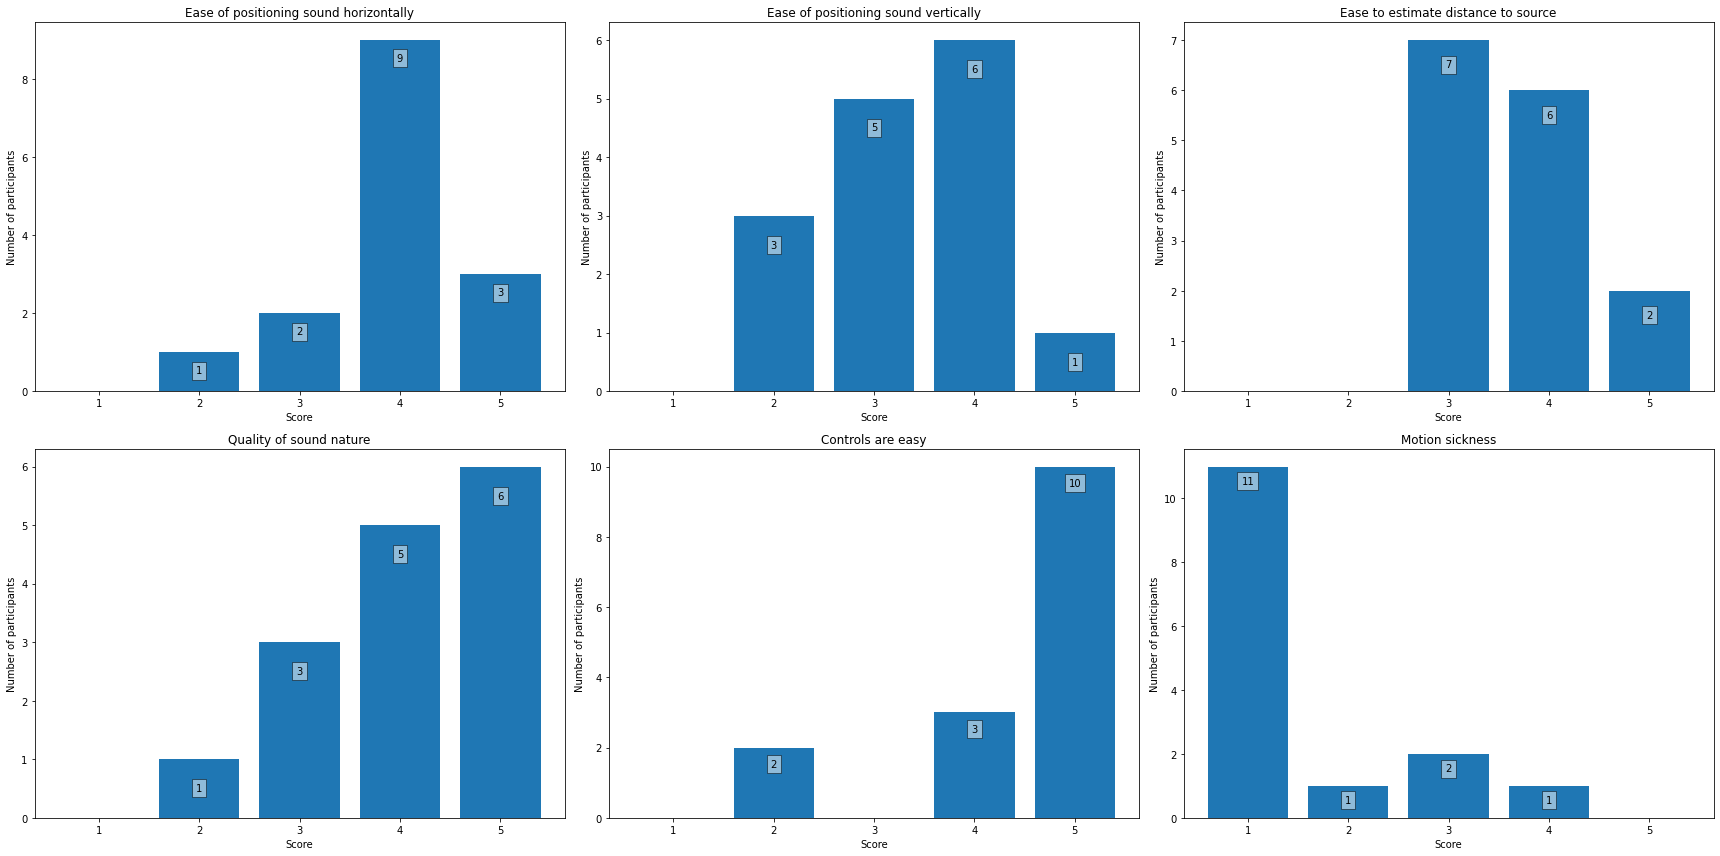

7 participants found positioning horizontally easier (46.67%)
2 participants found positioning horizontally harder (13.33%)
6 participants found positioning horizontally similar to positioning vertically (40.0%)


In [9]:
_, axs = plt.subplots(2, 3, figsize=(24, 12))

kwargs = {
    'x': range(1, 6),
    "label_x": "Score",
    "label_y": "Number of participants"
}

create_bar(
    y=hpos_scores,
    title="Ease of positioning sound horizontally",
    axis=axs[0, 0],
    **kwargs
)

create_bar(
    y=vpos_scores,
    title="Ease of positioning sound vertically",
    axis=axs[0, 1],
    **kwargs
)

create_bar(
    y=sound_dist_est,
    title="Ease to estimate distance to source",
    axis=axs[0, 2],
    **kwargs
)

create_bar(
    y=sound_nature,
    title="Quality of sound nature",
    axis=axs[1, 0],
    **kwargs
)

create_bar(
    y=controls_score,
    title="Controls are easy",
    axis=axs[1, 1],
    **kwargs
)

create_bar(
    y=motion_sickness_score,
    title="Motion sickness",
    axis=axs[1, 2],
    **kwargs
)
plt.tight_layout()
plt.show()

# Percentage of people that found it easier to position horizontally
h_easier = participants_df['HPosScore'] > participants_df["VPosScore"]
h_v_same = participants_df['HPosScore'] == participants_df["VPosScore"]
h_harder = participants_df['HPosScore'] < participants_df["VPosScore"]

h_easier = h_easier.value_counts()[True]
h_harder = h_harder.value_counts()[True]
h_v_same = h_v_same.value_counts()[True]

total_participants = len(participants_df)

print(h_easier, f"participants found positioning horizontally easier ({percentage(h_easier, total_participants)})")
print(h_harder, f"participants found positioning horizontally harder ({percentage(h_harder, total_participants)})")
print(h_v_same,
      f"participants found positioning horizontally similar to positioning vertically ({percentage(h_v_same, total_participants)})")

Most participants found it easy to position the sound horizontally. Only 1 out of 15 found it relatively hard to position the sounds to the left or to the right while performing the experiment.

Vertical position was also relatively easy for most participants, but some mentioned after the experiment that they found it harder to position it vertically in comparison to the horizontal direction.

Estimating the distance to the sound source was for most people not easy, as indicated by the 7 people that gave it a score of 3.
Only 2 believed that they could easily pinpoint the distance to the sound origin.

The nature of the sound is experienced by most participants as qualitative. They found the way in which the sounds volume changed fitting to their experience. One participant gave it a lower score. Another participant mentioned that he heard the cut-off of when a sound stopped playing as he moved out of the sounds range. The others did not mention any of this.

The controls using the controllers was easy and intuitive for most participants.

Most participants did not experience motion sickness during the experiment. Four people gave it a higher score than 1, with one person giving it a score of 4.

#### Participant feedback
 - *"Easy to control, fun, easy controls"*
 - *"Very fun to do!"*
 - *"I was completely involved. The main goal is to collect the coins, I heard the sounds, but was not bothered to look closer into it."*
 - *"At the start, using the controllers was harder. The further the experiment went, the better I could handle it."*
 - *"There is a certain distance at which the sound drops drastically. This was worse with some sounds."*
 - *"The audio in the room was the hardest to localize."*

## SFX Data

The following sections contain code blocks to extract metrics from the SFX datasets.
First it is checked which sound format is looked at the most, second there is checked how much unique participants looked at a sound format on average and finally, the gaze duration is calculated for each sound type.

The next table explains the abbreviations used further in this document.

### SFX Type Explanation

| Abreviation | Sound type                       |
|-------------|----------------------------------|
| NUS         | Non-ambisonic, Unity Spatialized |
| NSS         | Non-ambisonic, Steam spatialized |
| NNS         | Non-ambisonic, Non-Spatialized   |
| AS          | Ambisonic, Steam Spatialized     |
| AN          | Ambisonic, Non-spatialized       |


In [10]:
# Combine all data
all_sfx_data = pd.concat(sfx_dfs)

def type_data(sfx_df):
    return sfx_df[["Name", "Type"]].value_counts()

def type_percentage(sfx_df):
    return sfx_df[["Name", "Type"]].value_counts(normalize=True).groupby('Type').sum()

In [11]:
type_data(all_sfx_data)

Name                         Type
creak                        NUS     38
ambisonic-chicken-edited     AS      32
door_crack                   NNS     25
ambisonic-duck-edited 1      AN      21
australian-currawong-edited  AS      18
elevator-edited              AN      16
cow                          NUS     11
cowbells                     NNS     11
bird                         NSS      9
bee                          NSS      2
dtype: int64

The '*creak*' sound is looked at the most in general, followed by '*ambisonic-chicken-edited*'
The '*bee*' sound is only looked at 2 times over 15 participants. It probably is looked at by accident in these cases.

In [12]:
type_percentage(all_sfx_data)

Type
AN     0.202186
AS     0.273224
NNS    0.196721
NSS    0.060109
NUS    0.267760
dtype: float64

By looking at percentages, grouped by the sound type, it is noticed that the ambisonic, spatialized sounds have the best performance.
Most people looked at the ambisonic sounds that were spatialized. 27.32% of the times there was looked at a sound, it was at an ambisonic spatialized sound.

The Unity spatialization works quite well, even for non-ambisonic sound formats. Non-ambisonic sounds with Unity spatialization are looked at 26.78% of the time.

If we compare ambisonic with non-ambisonic, then we see that in 47.54% of the cases, people looked in the direction of the sound.
Note that there is one class of non-ambisonic sounds more, which might be the reason for the higher percentage here.

In the following subsection, we look at the difference in look distance.

In [13]:
# Same but based on distance now
data_look_close = all_sfx_data[all_sfx_data.RangeType.eq("close")]
data_look_medium = all_sfx_data[all_sfx_data.RangeType.eq("medium")]
data_look_far = all_sfx_data[all_sfx_data.RangeType.eq('far')]

#### Far distance from source

In [14]:
type_data(data_look_far)

Name                         Type
creak                        NUS     31
ambisonic-chicken-edited     AS      23
door_crack                   NNS     23
elevator-edited              AN      15
ambisonic-duck-edited 1      AN      14
australian-currawong-edited  AS      14
cow                          NUS     11
cowbells                     NNS     11
bird                         NSS      9
bee                          NSS      2
dtype: int64

In [15]:
type_percentage(data_look_far)

Type
AN     0.189542
AS     0.241830
NNS    0.222222
NSS    0.071895
NUS    0.274510
dtype: float64

Since most data points are related to looking at a far distance from the source, no significant difference with the conclusions from previous section can be deduced.

#### Medium distance from source

In [16]:
type_data(data_look_medium)

Name                         Type
ambisonic-duck-edited 1      AN      7
ambisonic-chicken-edited     AS      6
creak                        NUS     6
australian-currawong-edited  AS      3
door_crack                   NNS     1
elevator-edited              AN      1
dtype: int64

In [17]:
type_percentage(data_look_medium)

Type
AN     0.333333
AS     0.375000
NNS    0.041667
NUS    0.250000
dtype: float64

In this type of data, a difference is noticed. In this case, it seems the ambisonic sound types outperform the non-ambisonic sound types.
In 70.83 % of the cases where a participant looked at a medium distance from the source, an ambisonic sound type is used. This is a significant difference
with the other sound classes.

#### Close distance from source

In [18]:
type_data(data_look_close)

Name                         Type
ambisonic-chicken-edited     AS      3
australian-currawong-edited  AS      1
creak                        NUS     1
door_crack                   NNS     1
dtype: int64

In [19]:
type_percentage(data_look_close)

Type
AS     0.666667
NNS    0.166667
NUS    0.166667
dtype: float64

The trend discovered with the medium sound distance continues in this data.
Note that there are not many data points in this class.
On the other hand, it is striking that again, the ambisonic sound type has the upper hand.

In [20]:
def by_sound_analysis(cdf):
    by_sound = cdf[['PersonID', 'Name', 'Type']]
    by_sound = by_sound.drop_duplicates()
    by_sound = by_sound.groupby(['Name', 'Type']).count().sort_values('PersonID', ascending=False).rename(columns={'PersonID': 'PersonIDs'})
    by_sound['%'] = by_sound['PersonIDs'].apply(lambda x: x / float(total_participants) * 100)
    return by_sound

In [21]:
by_sound_analysis(all_sfx_data).head(10)

,,PersonIDs,%
Name,Type,,
creak,NUS,15,100.000000
door_crack,NNS,13,86.666667
ambisonic-chicken-edited,AS,11,73.333333
cowbells,NNS,9,60.000000
australian-currawong-edited,AS,8,53.333333
elevator-edited,AN,8,53.333333
ambisonic-duck-edited 1,AN,7,46.666667
bird,NSS,6,40.000000
cow,NUS,6,40.000000


In [22]:
by_sound_analysis(all_sfx_data).groupby("Type").mean() # TODO, text

,PersonIDs,%
Type,,
AN,7.5,50.000000
AS,9.5,63.333333
NNS,11.0,73.333333
NSS,3.5,23.333333
NUS,10.5,70.000000


Each participant looked at the creak sound. The bee sound was the hardest to localize: only one participant managed to look at it, probably by accident.
No siginificant difference between the ambisonic and non-ambisonic sounds can be determined.

Whether a participant looks at a sound is completely determined by the specific sound.
There is no correlation with the sound type.
Again, this can be subdivided into the different range types.

In [23]:
by_sound_far = all_sfx_data[all_sfx_data.RangeType == "far"]
print("FAR RANGE")
by_sound_analysis(by_sound_far)

FAR RANGE


,,PersonIDs,%
Name,Type,,
creak,NUS,15,100.000000
door_crack,NNS,13,86.666667
ambisonic-chicken-edited,AS,10,66.666667
cowbells,NNS,9,60.000000
australian-currawong-edited,AS,8,53.333333
elevator-edited,AN,8,53.333333
ambisonic-duck-edited 1,AN,7,46.666667
bird,NSS,6,40.000000
cow,NUS,6,40.000000


In [24]:
by_sound_analysis(by_sound_far).groupby("Type").mean() # TODO, text

,PersonIDs,%
Type,,
AN,7.5,50.000000
AS,9.0,60.000000
NNS,11.0,73.333333
NSS,3.5,23.333333
NUS,10.5,70.000000


In [25]:
by_sound_medium = all_sfx_data[all_sfx_data.RangeType == "medium"]
print("MEDIUM RANGE")
by_sound_analysis(by_sound_medium)

MEDIUM RANGE


,,PersonIDs,%
Name,Type,,
ambisonic-duck-edited 1,AN,6,40.000000
creak,NUS,5,33.333333
ambisonic-chicken-edited,AS,3,20.000000
australian-currawong-edited,AS,2,13.333333
door_crack,NNS,1,6.666667
elevator-edited,AN,1,6.666667


In [26]:
by_sound_analysis(by_sound_medium).groupby("Type").mean() # TODO, text

,PersonIDs,%
Type,,
AN,3.5,23.333333
AS,2.5,16.666667
NNS,1.0,6.666667
NUS,5.0,33.333333


In [27]:
by_sound_close = all_sfx_data[all_sfx_data.RangeType == "close"]
print("CLOSE RANGE")
by_sound_analysis(by_sound_close)

CLOSE RANGE


,,PersonIDs,%
Name,Type,,
ambisonic-chicken-edited,AS,2,13.333333
australian-currawong-edited,AS,1,6.666667
creak,NUS,1,6.666667
door_crack,NNS,1,6.666667


In [28]:
by_sound_analysis(by_sound_close).groupby("Type").mean() # TODO, text

,PersonIDs,%
Type,,
AS,1.5,10.000000
NNS,1.0,6.666667
NUS,1.0,6.666667


Most people looked relatively far away from the sound source.
If participants looked closer to a sound, it is noted that the type of the sound is more likely to be an ambisonic sound format.
The data in previous cells shows this hypothesis.

### Average duration looked at sounds

In [29]:
pd.options.mode.chained_assignment = None  # default='warn'
duration_data = all_sfx_data[['LookStart', 'LookEnd', 'Type', 'Name']]
duration_data['Duration (s)'] = duration_data['LookEnd'] - duration_data['LookStart']
duration_data['Duration (s)'] = duration_data['Duration (s)'].dt.total_seconds().astype(float)
duration_data['Duration (s)'] = duration_data['Duration (s)'].apply(func=lambda x: .1 if x == 0 else x)
duration_data.drop(['LookStart', 'LookEnd'], inplace=True, axis=1)
duration_data

,Type,Name,Duration (s)
0,AS,ambisonic-chicken-edited,0.1
1,NSS,bird,1.0
2,NUS,creak,1.0
3,NNS,door_crack,0.1
4,NNS,door_crack,2.0
...,...,...,...
4,AN,ambisonic-duck-edited 1,1.0
5,AN,elevator-edited,1.0
6,NUS,creak,1.0
7,NUS,creak,0.1


In [30]:
sums = duration_data.groupby(['Name', 'Type']).sum()
sums.sort_values('Duration (s)', ascending=False, inplace=True)
sums.head(100)

,,Duration (s)
Name,Type,
ambisonic-chicken-edited,AS,41.2
creak,NUS,27.2
door_crack,NNS,26.0
ambisonic-duck-edited 1,AN,24.9
australian-currawong-edited,AS,13.0
bird,NSS,9.4
cow,NUS,7.5
elevator-edited,AN,5.2
cowbells,NNS,4.9


In [31]:
averages = duration_data.groupby(['Name', 'Type']).mean()
averages.sort_values('Duration (s)', ascending=False, inplace=True)
averages.head(100)

,,Duration (s)
Name,Type,
bee,NSS,1.500000
ambisonic-chicken-edited,AS,1.287500
ambisonic-duck-edited 1,AN,1.185714
bird,NSS,1.044444
door_crack,NNS,1.040000
australian-currawong-edited,AS,0.722222
creak,NUS,0.715789
cow,NUS,0.681818
cowbells,NNS,0.445455


In [32]:
averages.groupby("Type").mean()

,Duration (s)
Type,
AN,0.755357
AS,1.004861
NNS,0.742727
NSS,1.272222
NUS,0.698804
